# Implementar un MLP con Backpropagation para resolver el problema de la función XOR 

<img src="figs/fig-MLP_XOR.png" width="60%">


1. **Definir la arquitectura de la red**:  
   - La red tendrá 2 entradas (los valores binarios del XOR), una capa oculta con 2 neuronas, y una neurona de salida.
   - Usar la función de activación sigmoide en las neuronas de la capa oculta y de salida.
   - Establecer una tasa de aprendizaje (ej. 0.5) y el número de épocas de entrenamiento.

   Por ejemplo, para la capa de salida (2 neuronas en la capa oculta, 1 neurona de salida):
 $$ W^{(2)} \in \mathbb{R}^{1 \times 2} $$
 $$ b^{(2)} \in \mathbb{R}^{1 \times 1} $$

2. **Inicializar los pesos y los sesgos**:  
   - Inicializar los pesos de las conexiones de la capa de entrada a la capa oculta y de la capa oculta a la capa de salida, de manera aleatoria (puedes usar la inicialización Xavier).
   - También inicializar los sesgos de cada capa.

3. **Propagación hacia adelante (Forward pass)**:  
   - Para cada entrada, multiplicar las entradas por los pesos de la capa oculta y sumar el sesgo.
   - Aplicar la función de activación (sigmoide) para obtener las activaciones de la capa oculta.
   - Repetir el proceso con los valores de la capa oculta para calcular la activación de la capa de salida.

4. **Calcular el error**:  
   - Calcular el error en la salida utilizando una función de error, como el Error Cuadrático Medio (MSE).

5. **Backpropagation (Propagación hacia atrás)**:  
   - Calcular los gradientes de error en la capa de salida
   - Propagar el error hacia la capa oculta, calculando el gradiente de error en la capa oculta.
   
6. **Actualizar los pesos y sesgos**:  
   - Usar los gradientes obtenidos para ajustar los pesos y los sesgos de la capa de salida y de la capa oculta utilizando el gradiente descendente.
   
7. **Repetir el entrenamiento**:  
   - Repetir los pasos de forward, cálculo de error y backpropagation por el número de épocas definido hasta que el error disminuya significativamente.

8. **Evaluar el modelo**:  
   - Después del entrenamiento, probar la red con las entradas XOR y verificar que las salidas estén cerca de los valores esperados (0 o 1).
   






In [21]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Función de activación sigmoide
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Derivada de la sigmoide
def sigmoid_derivative(x):
    return x * (1 - x)

# Establece la semilla para la generación de números aleatorios
def seed(random_state=33):
    np.random.seed(random_state)

# Inicialización de javier
def xavier_initialization(input_size, output_size):
    # ¿En el parametro size es output, input?
    return np.random.normal(scale=np.sqrt(2 / (input_size + output_size)), size=(output_size, input_size))

# Inicialización normal
def normal_initialization(input_size, output_size):
    return np.random.randn(output_size, input_size) * 0.1

# Preprocesado de datos
def preprocesar(ruta):
    datos = pd.read_csv(ruta, header=0)
    datos_crudos = datos.to_numpy()

    x = datos_crudos[:, :-1]
    y = datos_crudos[:, -1:]

    return x, y

# Normalizar los datos
def normalizar_datos(X):
    scaler = StandardScaler()
    return scaler.fit_transform(X)

# Crear mini lotes
def create_minibatches(X, y, batch_size):
    """
    Genera los lotes de datos (batchs) de acuerdo al parámetro batch_size de forma aleatoria para el procesamiento. 
    """
    n_samples = X.shape[0]
    indices = np.random.permutation(n_samples)  # Mezcla los índices aleatoriamente
    X_shuffled, y_shuffled = X[indices], y[indices]  # Reordena X e y según los índices aleatorios
    
    # Divide los datos en minibatches
    for X_batch, y_batch in zip(np.array_split(X_shuffled, np.ceil(n_samples / batch_size)), 
                                np.array_split(y_shuffled, np.ceil(n_samples / batch_size))):
        yield X_batch, y_batch


class MLP_TODO:
    def __init__(self, num_entradas, num_neuronas_ocultas, num_salidas, epochs, 
                 batch_size=128, learning_rate=0.2, random_state=42, initialization="xavier"):

        # Construcción
        seed(random_state)
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        
        self.error_mse = []
        self.accuracy_epoca = []
        
        # definir las capas
        if initialization == 'xavier':
            init_fun = xavier_initialization
        else : 
            init_fun = normal_initialization

        self.W1 = init_fun(num_entradas, num_neuronas_ocultas)
        self.b1 = np.zeros((1, num_neuronas_ocultas))
        self.W2 = init_fun(num_neuronas_ocultas, num_salidas)
        self.b2 = np.zeros((1, num_salidas))

    def forward(self, X):
        #----------------------------------------------
        # 1. Propagación hacia adelante (Forward pass)
        #----------------------------------------------
        self.X = X
        self.z_c1 = X @ self.W1.T + self.b1
        self.a_c1 = sigmoid(self.z_c1)
        self.z_c2 = self.a_c1 @ self.W2.T + self.b2
        y_pred = sigmoid(self.z_c2)  # Y^
        return y_pred

    def loss_function_MSE(self, y_pred, y):
        #----------------------------------------------
        # 2. Cálculo del error con MSE
        #----------------------------------------------
        self.y_pred = y_pred
        self.y = y
        error = 0.5 * np.mean((y_pred - y) ** 2)
        return error
    
    def backward(self):
        #----------------------------------------------
        # 3. Propagación hacia atrás (Backward pass)
        #----------------------------------------------
        
        #----------------------------------------------
        # Gradiente de la salida
        #----------------------------------------------
        dE_dy_pred = (self.y_pred - self.y) / self.y.shape[0] # Derivada del error respecto a la predicción con  N ejemplos
        d_y_pred_d_zc2 = sigmoid_derivative(self.y_pred)
        delta_c2 = dE_dy_pred * d_y_pred_d_zc2

        #----------------------------------------------
        # Gradiente en la capa oculta
        #----------------------------------------------
        # calcular la derivada de las suma ponderada respecto a las activaciones de la capa 1
        delta_c1 = (delta_c2 @ self.W2) * sigmoid_derivative(self.a_c1)

        #calcula el gradiente de pesos y bias
        self.dE_dW2 = delta_c2.T @ self.a_c1
        self.dE_db2 = np.sum(delta_c2, axis=0, keepdims=True)
        self.dE_dW1 = delta_c1.T @ self.X
        self.dE_db1 = np.sum(delta_c1, axis=0, keepdims=True)

    def update(self):  # Ejecución de la actualización de paramámetros
        #----------------------------------------------
        # Actualización de pesos de la capa de salida
        #---------------------------------------------- 
        
        self.W2 = self.W2 - self.learning_rate * self.dE_dW2 # Ojito con la T
        self.b2 = self.b2 - self.learning_rate * self.dE_db2

        #----------------------------------------------
        # Actuailzación de pesos de la capa oculta
        #----------------------------------------------
        #calcula el gradiente de la función de error respecto a los pesos de la capa 1
        self.W1 = self.W1 - self.learning_rate * self.dE_dW1
        self.b1 = self.b1 - self.learning_rate * self.dE_db1

    def predict(self, X):  # Predecir la categoría para datos nuevos
        y_pred = self.forward(X)
        # Obtener la clase para el clasificador binario
        y_pred = np.where(y_pred >= 0.5, 1, 0)
        return y_pred

    def train(self, X, Y):
        for epoch in range(self.epochs):

            num_batch = 0
            epoch_error  = 0

            # Procesamiento por lotes
            for X_batch, y_batch in create_minibatches(X, Y, self.batch_size):
                y_pred = self.forward(X_batch)
                error = self.loss_function_MSE(y_pred, y_batch)
                
                # if np.all(y_pred == Y) : aciertos += 1
                # self.accuracy_epoca.append(aciertos/epoch)

                epoch_error += error
                self.backward() # cálculo de los gradientes
                self.update() # actualización de los pesos y bias
                num_batch += 1
                # Imprimir el error cada N épocas
            
            # Almacena el error promedio por época
            self.error_mse.append(epoch_error/num_batch)

            # Obtener predicciones binarias para todo el conjunto de entrenamiento
            y_pred_total = self.predict(X)

            # Calcular la exactitud
            exactitud = self.calcular_accuracy(y_pred_total, Y) 
            
            # Almacenar la exactitud de la época
            self.accuracy_epoca.append(exactitud)

            #if epoch % 100 == 0: print(f"Época {epoch:05d} | MSE: {epoch_error/num_batch:.6f} | Exactitud: {exactitud:.4f}")

    def graficar(self, graficar_exactitud=False, guardar=True, nombre="grafica"):
        """ 
        Para MSE siempre se muestra 
        """
        # Preparar datos
        mse = np.arange(len(self.error_mse))

        # Crear tabla
        plt.figure(figsize=(10,6))

        #Graficar MSE
        plt.plot(mse, self.error_mse, label="MSE", color="red", linewidth=1)


        """ 
        Para la exactitud 
        """
        if graficar_exactitud and len(self.accuracy_epoca) > 0:
            accuracy = np.arange(len(self.accuracy_epoca))
            plt.plot(accuracy, self.accuracy_epoca, label="Exactitud", color="green", linewidth=1)
            plt.ylabel("MSE / Exactitud")
            titulo = "Evolución del Error (MSE) y Exactitud durante el entrenamiento"
        else:
            plt.ylabel("Error Cuadrático Medio (MSE)")
            titulo = "Evolución del Error (MSE) durante el entrenamiento"

        plt.title(titulo)
        plt.xlabel("Época")
        plt.legend()
        plt.grid(True, alpha=0.3)

        if guardar:
            plt.savefig(f'{nombre}.svg')
        plt.show()

    def calcular_accuracy(self, y_pred, y_verdadera):
        return np.mean(y_verdadera.flatten() == y_pred.flatten())

    def analizar(self, X, y):
        # Gráficar
        self.graficar(guardar=True)

        # Valores reales y predicción
        y_pred = self.predict(X)
        print(f"valores reales: {y.flatten()}")
        print(f"Predicciones  : {y_pred.flatten()}")

        # Calcular exactitud
        exactitud = self.calcular_accuracy(y_pred, y)
        print(f"Exactitud: {exactitud}")


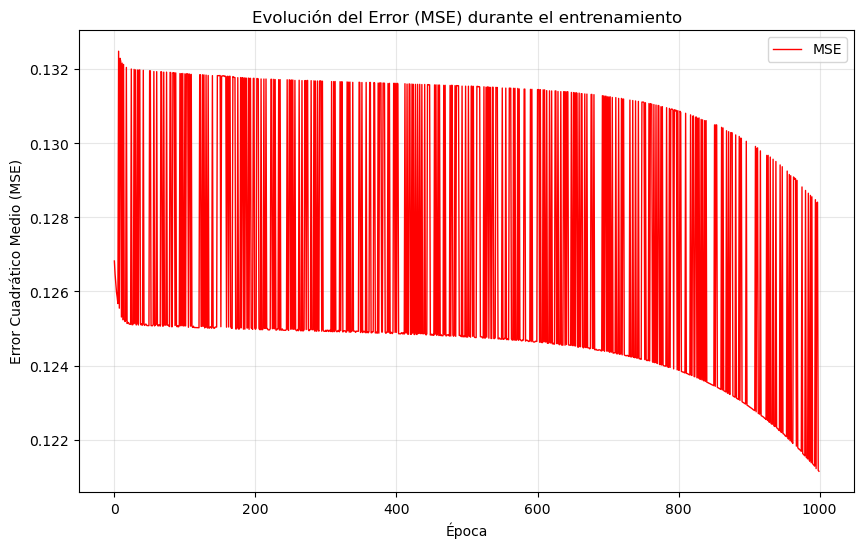

valores reales: [0 1 1 0]
Predicciones  : [0 1 1 1]
Exactitud: 0.75


In [22]:
#Ejemplo del uso para el entrenamiento

# Definimos los datos de entrada para XOR
X = np.array([[0, 0],
              [0, 1],
              [1, 0],
              [1, 1]])

# Salidas esperadas para XOR
y = np.array([[0],[1],[1],[0]])

entradas = 2
neuronas_ocultas = 2
salidas = 1
batch_size = 2 # Batch de 2 ejemplos # X.shape[0] # Batch de todos los ejemplos
# batch_size = X.shape[0] # Batch de todos los ejemplos
learning_rate = 0.5
epochs = 1000
clasificador_XOR = MLP_TODO(entradas, neuronas_ocultas, salidas, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate)
clasificador_XOR.train(X,y)

clasificador_XOR.analizar(X, y)

# Preprocesamiento de datos

In [6]:
ruta = "./datasets/iris_train.csv"
iris_x, iris_y = preprocesar(ruta=ruta)
print(normalizar_datos(iris_x))

[[ 0.39315746  2.71956762 -0.95721147 -0.69925603]
 [ 2.33867889  0.03612329  1.42705153  1.28572882]
 [-0.74173005 -2.23448345  0.44529618  0.38346298]
 [ 0.23103067 -0.17029551  1.14655     1.28572882]
 [ 1.20379139 -1.82164586  1.14655     1.28572882]
 [-1.39023719  0.65537967 -1.02733685 -0.87970919]
 [-0.0932229   0.65537967 -0.95721147 -0.69925603]
 [-0.41747647 -0.78955189  0.72579771  1.10527565]
 [-0.57960326  1.48105485 -0.88708609 -1.06016236]
 [ 0.39315746 -0.5831331   0.86604847  0.92482249]
 [-0.90385683  0.03612329 -0.95721147 -1.06016236]
 [-0.74173005  0.24254208 -1.16758762 -1.06016236]
 [ 2.01442531  0.03612329  1.28680077  1.28572882]
 [ 0.87953781 -0.3767143   1.14655     1.28572882]
 [ 0.06890388 -1.20238948  0.79592309  0.92482249]
 [-1.55236398 -1.61522707 -1.09746223 -0.87970919]
 [ 0.06890388 -1.40880827  0.65567232  0.56391615]
 [-1.2281104   0.24254208 -1.09746223 -1.06016236]
 [-1.06598362 -0.17029551 -1.02733685 -1.24061553]
 [ 1.52804496 -0.3767143   1.00

$$\text{Accuracy} = \frac{N_{\text{aciertos}}}{N_{\text{total}}}$$